# DEM

In [1]:
import os
from collections import OrderedDict
import sys
import copy
import pandas
import numpy as np
from scipy.interpolate import splev
import matplotlib.pyplot as plt
import urllib
import roman
import fiasco
from fiasco.util import burgess_tully_descale,burgess_tully_descale_vectorize
from astropy.table import QTable
import astropy.units as u
import astropy.constants as const
import astropy.time
from sunpy.net import Fido,attrs
from sunpy.map import Map
from sunpy.time import TimeRange
from sunpy.instr.aia import aiaprep
import hissw
from synthesizAR.instruments import InstrumentSDOAIA
from scipy.integrate import simps

from dem2 import HannahKontarModel

sys.path.append('../thesis/chapter3/python')
from run_ebtel import run_ebtel
from dem import plot_hist

%matplotlib inline

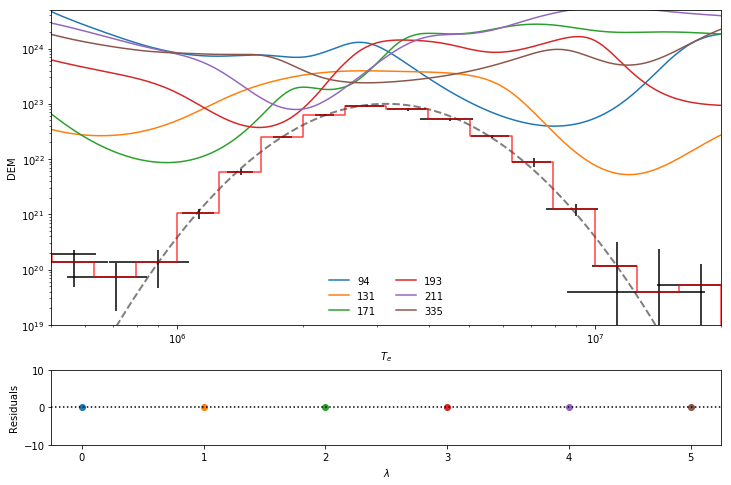

In [18]:
DEMREG_DIR = '/Users/willbarnes/Documents/work/codes/demreg/idl/'
# Create DEM
T0 = 10**(6.5)*u.K
sigma = 0.15
dem_total = 3.76e22*u.cm**(-5)*u.K**(-1)
T = 10**np.arange(5.5,7.5,0.01)*u.K
dem_true = dem_total/(np.sqrt(2*np.pi)*sigma)*np.exp(-((np.log10(T.value) - np.log10(T0.value))**2)/(2*sigma**2))
# Calculate intensities
aia = InstrumentSDOAIA([0,1]*u.s,None)
I_true = [(dem_true.value
           *splev(T.value, c['temperature_response_spline'])
           *np.gradient(T).value).sum()
          for c in aia.channels]
# Run regularized inversion code
ssw = hissw.ScriptMaker(
    ssw_packages=['sdo/aia'],
    ssw_paths=['aia','xrt'],
    extra_paths=[DEMREG_DIR]
)
script = """
data = {{data}}
; Calculate errors
nchannels = n_elements(data)
data_errors=fltarr(nchannels)
exptimes = [2.901051,2.901311,2.000197,1.999629,2.901278,2.900791]
channels = [94,131,171,193,211,335]
;common aia_bp_error_common,common_errtable
;common_errtable=aia_bp_read_error_table('{{ aia_error_table_filename }}')
;for i=0,nchannels-1 do begin
;    norm=exptimes[i]
;    data_errors[i]=aia_bp_estimate_error(data[i]*norm,channels[i],n_sample=1)
;    data_errors[i]=data_errors[i]/exptimes[i]
;endfor
data_errors = sqrt(data)
; Get temperature bins
response_logt = {{log_temperature}}
temperature = {{temperature_bin_edges}}
; Calculate response functions
response_matrix = {{ response_matrix }}
; DEM Calculation
dn2dem_pos_nb,data,data_errors,response_matrix,response_logt,temperature,dem,dem_errors,logt_errors,chi_squared,dn_regularized,reg_tweak=1
"""
T_bins = 10**(np.arange(5.5,7.5,0.1))*u.K
T_bins_centers = (T_bins[1:] + T_bins[:-1])/2.
K_matrix = np.stack([
    splev(T_bins_centers.value, c['temperature_response_spline']) for c in aia.channels
])
input_args =  {
    'log_temperature': np.log10(T_bins_centers.value).tolist(),
    'temperature_bin_edges': T_bins.value.tolist(),
    'aia_error_table_filename': os.path.join(ssw.ssw_home, 'sdo/aia/response/aia_V2_error_table.txt'),
    'data': I_true,
    'response_matrix': K_matrix.tolist(),
}
save_vars = ['dem', 'dem_errors', 'logt_errors', 'data_errors']
reg = ssw.run(script, args=input_args, save_vars=save_vars,verbose=False)
# Calculate DEM intensities
I_dem = [(splev(T_bins_centers.value, c['temperature_response_spline'])
          *reg['dem']
          *np.diff(T_bins.value)).sum() for c in aia.channels]
# Plot
fig = plt.figure(figsize=(12,8))
## true DEM
ax = plt.subplot2grid((4,1),(0,0),rowspan=3)
ax.plot(T, dem_true, color='k', alpha=0.5, ls='--',lw=2)
## EM loci
for i,c in enumerate(aia.channels):
    K = splev(T.value,c['temperature_response_spline'])
    ax.plot(T, I_true[i]/K/np.gradient(T)/4/np.pi, 
            label=f"{c['name']}")
## regularized DEM
ax.errorbar(
    T_bins_centers.value, reg['dem'], 
    yerr=reg['dem_errors'],
    xerr=(T_bins_centers.value*(10**(reg['logt_errors']/2) - 1),
          T_bins_centers.value*(1 - 10**(-reg['logt_errors']/2))),
    color='k',marker='',ls='')
plot_hist(ax,reg['dem'],T_bins.value,color='r',alpha=0.75)
## labels and limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e19,5e24)
ax.set_xlim(5e5,2e7)
ax.set_xlabel(r'$T_e$')
ax.set_ylabel(r'DEM')
ax.legend(frameon=False,ncol=2,loc='lower center')
## residuals
ax = plt.subplot2grid((4,1),(3,0),rowspan=1)
for i in range(len(I_true)):
    ax.plot(i,np.fabs(I_true[i] - I_dem[i])/reg['dem_errors'][i],marker='o',ls='')
## labels and limits
ax.set_ylim(-10,10)
ax.axhline(y=0, ls=':', color='k')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Residuals')
plt.subplots_adjust(hspace=0.6)

## Regularized Inversion

First, create a single-Gaussian DEM

In [157]:
T0 = 10**(6.5)*u.K
sigma = 0.15
dem_total = 3.76e22*u.cm**(-5)*u.K**(-1)
T = 10**np.arange(5.5,7.5,0.01)*u.K
dem = dem_total/(np.sqrt(2*np.pi)*sigma)*np.exp(-((np.log10(T.value) - np.log10(T0.value))**2)/(2*sigma**2))

Next, synthesize AIA intensities from this DEM.

In [158]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [159]:
intensities = {}
for c in aia.channels:
    K = splev(T.value,c['temperature_response_spline'])*u.count/u.s/u.pixel*u.cm**5
    intensities[c['name']] = simps((K*dem).value,x=T.value)

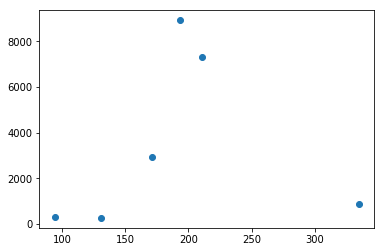

In [161]:
plt.plot([c['wavelength'].value for c in aia.channels],[intensities[c['name']] for c in aia.channels],marker='o',ls='')

(1e+19, 5e+24)

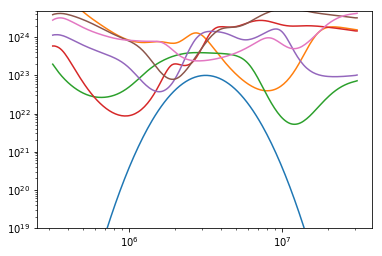

In [162]:
plt.plot(T,dem)
for c in aia.channels:
    K = splev(T.value,c['temperature_response_spline'])*u.count/u.s/u.pixel*u.cm**5
    plt.plot(T,intensities[c['name']]/K/np.gradient(T)/4/np.pi,label=c['name'])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e19,5e24)

In [36]:
ssw = hissw.ScriptMaker(
    ssw_packages=['sdo/aia'],
    ssw_paths=['aia','xrt'],
    extra_paths=['/Users/willbarnes/Documents/work/codes/demreg/idl/']
)

In [74]:
script = """
data = {{data}}

; Calculate errors
{% if percent_error is defined %}
data_errors = {{ percent_error }}*data
{% else %}
nchannels = n_elements(data)
data_errors=fltarr(nchannels)
exptimes = [2.901051,2.901311,2.000197,1.999629,2.901278,2.900791]
channels = [94,131,171,193,211,335]
common aia_bp_error_common,common_errtable
common_errtable=aia_bp_read_error_table('{{ aia_error_table_filename }}')
for i=0,nchannels-1 do begin
    norm_factor = exptimes[i]
    data_errors[i]=aia_bp_estimate_error(data[i]*norm_factor,channels[i],n_sample={{ n_sample }})
    data_errors[i]=data_errors[i]/exptimes[i] ;Is this the right thing to do?
endfor
{% endif %}

; Get temperature bins
response_logt = {{log_temperature}}
temperature = {{temperature_bin_edges}}

; Calculate response functions
response_matrix = {{ response_matrix }}

; DEM Calculation
dn2dem_pos_nb,data,data_errors,response_matrix,response_logt,temperature,dem,dem_errors,logt_errors,chi_squared,dn_regularized
"""

In [75]:
temperature_bins = 10**(np.arange(5.5,7.5,0.1))*u.K
response_matrix = np.stack([
    splev(((temperature_bins[1:] + temperature_bins[:-1])/2.).value, c['temperature_response_spline']) for c in aia.channels
])
input_args =  {
    'log_temperature': np.log10(((temperature_bins[1:] + temperature_bins[:-1])/2.).to(u.K).value).tolist(),
    'temperature_bin_edges': temperature_bins.to(u.K).value.tolist(),
    #'percent_error': 0.05,
    'n_sample':1,
    'aia_error_table_filename': os.path.join(ssw.ssw_home, 'sdo/aia/response/aia_V2_error_table.txt'),
    'data': [intensities[c['name']].value for c in aia.channels],
    'response_matrix': response_matrix.tolist(),
}

In [76]:
save_vars = ['dem', 'dem_errors', 'logt_errors', 'chi_squared', 'dn_regularized', 'data_errors']

In [77]:
res = ssw.run(script,args=input_args,save_vars=save_vars,)

IDL 8.7.0 (darwin x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
A new version is available: IDL 8.7.1
https://harrisgeospatial.flexnetoperations.com
 
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 110
% Compiled module: HISSW_PROCEDURE.
% Compiled module: AIA_BP_READ_ERROR_TABLE.
% Compiled module: RD_TFILE.
% Compiled module: AIA_BP_ESTIMATE_ERROR.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.

SSW  setup will include: <gen 

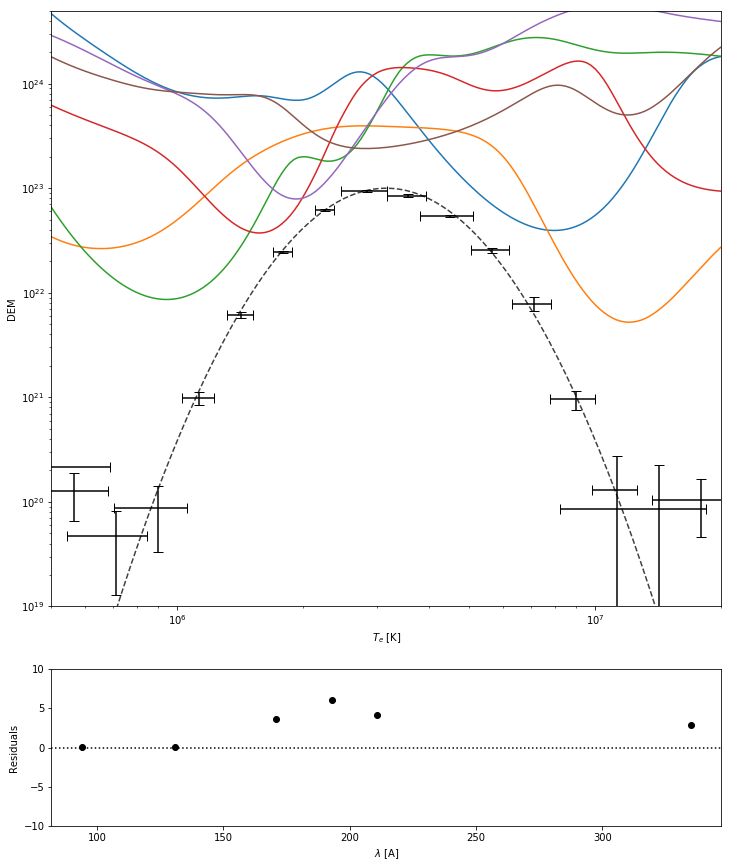

In [93]:
fig = plt.figure(figsize=(12,15))
ax = plt.subplot2grid((4,1),(0,0),rowspan=3)
# Real DEM
ax.plot(T,dem,color='k',ls='--',alpha=0.75)
# EM Loci curves
for c in aia.channels:
    K = splev(T.value,c['temperature_response_spline'])*u.count/u.s/u.pixel*u.cm**5
    ax.plot(T,intensities[c['name']]/K/np.gradient(T)/4/np.pi,label=c['name'])
# Recovered DEM
temperature_bin_centers = ((temperature_bins[1:] + temperature_bins[:-1])/2.)
ax.errorbar(
    temperature_bin_centers.value, res['dem'], 
    yerr=res['dem_errors'],
    xerr=(temperature_bin_centers.value*(10**(res['logt_errors']/2) - 1),
          temperature_bin_centers.value*(1 - 10**(-res['logt_errors']/2))),
    color='k',marker='',ls='',capsize=5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e19,5e24)
ax.set_xlim(5e5,2e7)
ax.set_xlabel(r'$T_e$ [K]')
ax.set_ylabel(r'DEM')
# Residuals
ax = plt.subplot2grid((4,1),(3,0),rowspan=1)
for i,c in enumerate(aia.channels):
    I_sim = (splev(temperature_bin_centers.value,c['temperature_response_spline'])*res['dem']*np.diff(temperature_bins.value)).sum()
    I_true = intensities[c['name']].value
    ax.plot(c['wavelength'].value, (I_true - I_sim)/res['data_errors'][i],
            marker='o',ls='',color='k')
ax.set_ylim(-10,10)
ax.axhline(y=0,ls=':',color='k')
ax.set_xlabel(r'$\lambda$ [A]')
ax.set_ylabel('Residuals')
plt.subplots_adjust(hspace=0.4)

Try with images?

In [2]:
q = Fido.search(
    attrs.Time(TimeRange('2012/02/11 15:00:00','2012/02/11 15:00:10')),
    attrs.Instrument('AIA'),
    attrs.Wavelength(90*u.angstrom,340*u.angstrom)
)

In [16]:
#files = Fido.fetch(q)
files = ['/Users/willbarnes/sunpy/data/aia_lev1_171a_2012_02_11t15_00_00_35z_image_lev1.1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_211a_2012_02_11t15_00_00_62z_image_lev1.1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_94a_2012_02_11t15_00_02_12z_image_lev1.1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_335a_2012_02_11t15_00_03_62z_image_lev1.1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_193a_2012_02_11t15_00_07_84z_image_lev1.1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_304a_2012_02_11t15_00_08_12z_image_lev1.1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_131a_2012_02_11t15_00_09_62z_image_lev1.1.fits']

In [38]:
maps = [Map(f) for f in files if '304' not in f]
maps = [Map(np.where(m.data<0,0,m.data),m.meta).resample([100,100]*u.pix) for m in maps]
wvl = u.Quantity([m.meta['wavelnth']*u.Unit(m.meta['waveunit']) for m in maps])
maps = [maps[i] for i in np.argsort(wvl)]

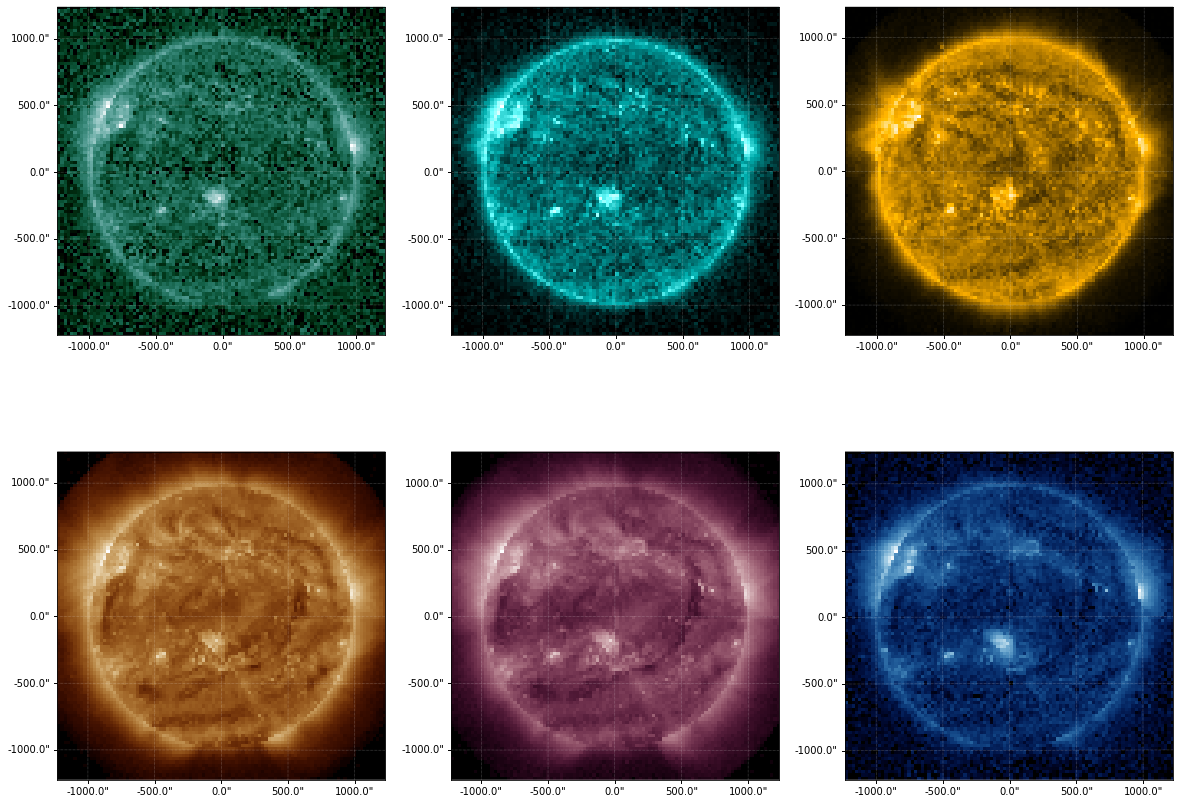

In [39]:
fig = plt.figure(figsize=(20,15))
for i in range(len(maps)):
    ax = fig.add_subplot(2,3,i+1,projection=maps[i])
    maps[i].plot(axes=ax,annotate=False,title=False)

In [40]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [41]:
temperature_bins = 10**(np.arange(5.25,7.5,0.25))*u.K
temperature_bin_centers = (temperature_bins[1:] + temperature_bins[:-1])/2
dem_hk = HannahKontarModel(maps, temperature_bins,[splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels],
                           dem_path='/Users/willbarnes/Documents/work/codes/demreg/idl/')

In [49]:
dem = dem_hk.fit(normalized=False,edge_trim=1,verbose=False,alpha_regularization=5)

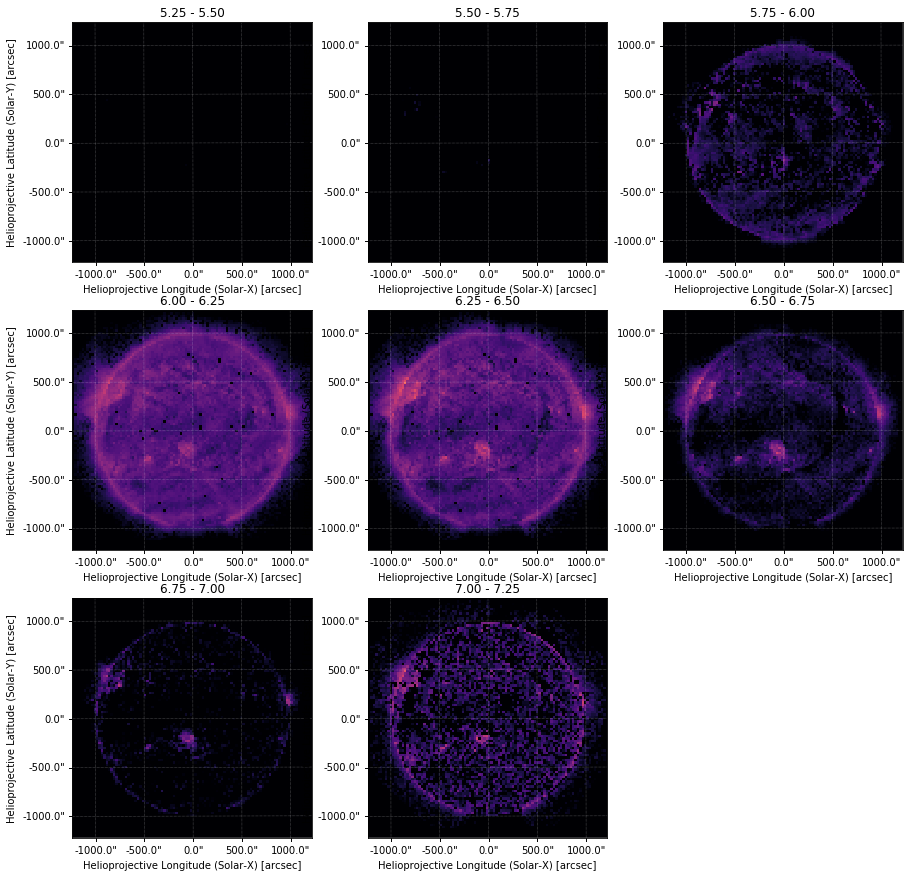

In [50]:
fig = plt.figure(figsize=(15,15))
for i,m in enumerate(dem):
    ax = fig.add_subplot(3,3,i+1,projection=m)
    m.plot(axes=ax,annotate=True,title=f'{np.log10(temperature_bins[i].value):.2f} - {np.log10(temperature_bins[i+1].value):.2f}',cmap='magma')

(1e+23, 1e+28)

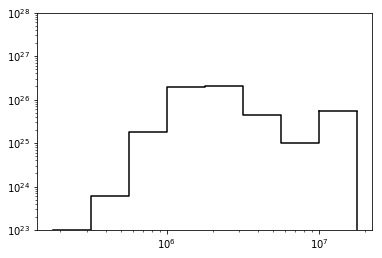

In [53]:
plot_hist(plt.figure().gca(),
          dem.get_1d_distribution(m.bottom_left_coord,m.top_right_coord).value,
          temperature_bins.value,
          color='k')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e23,1e28)

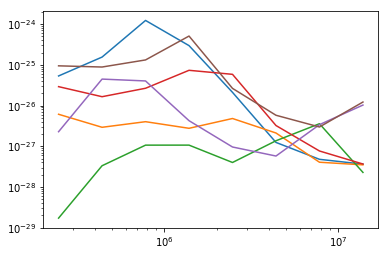

In [37]:
for k in dem_hk.response:
    plt.plot(temperature_bin_centers,k)
plt.xscale('log')
plt.yscale('log')

In [33]:
dem_hk.maps

[SunPy Map
 ---------
 Observatory:		 SDO
 Instrument:		 AIA 4
 Detector:		 AIA
 Measurement:		 94.0 Angstrom
 Wavelength:		 94.0 Angstrom
 Observation Date:	 2012-02-11 15:00:02
 Exposure Time:		 2.902070 s
 Dimension:		 [100. 100.] pix
 Coordinate System:	 helioprojective
 Scale:			 [24.58046464 24.58046464] arcsec / pix
 Reference Pixel:	 [50.5 50.5] pix
 Reference Coord:	 [-7.80368307  6.57196963] arcsec
 array([[3.9200e-02, 0.0000e+00, 9.0000e-01, ..., 2.0000e-03, 9.2240e-01,
         1.9208e+00],
        [1.2000e-03, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         3.7600e-02],
        [1.9600e-01, 0.0000e+00, 1.8000e-01, ..., 8.3000e-01, 0.0000e+00,
         1.9780e+00],
        ...,
        [1.8000e-02, 2.0880e+00, 1.8000e-01, ..., 1.1000e-01, 0.0000e+00,
         0.0000e+00],
        [2.7824e+00, 8.8720e-01, 1.6980e+00, ..., 0.0000e+00, 8.8720e-01,
         9.8000e-01],
        [4.0000e-04, 0.0000e+00, 2.0000e-02, ..., 0.0000e+00, 4.0000e-02,
         1.9404e+00]]

## Model

In [17]:
def calculate_em(t,T,n,L,bins_T=None):
    # Create bins
    if bins_T is None:
        bins_T = 10**(np.arange(4,8.5,0.05))*u.K
    bins_t = np.concatenate((t[:1], (t[1:] + t[:-1])/2., t[-1:])).value*t.unit
    # Make 2D histogram
    H,_,_ = np.histogram2d(
        T.value, t.value,
        bins=(bins_T.value, bins_t.value),
        weights=np.gradient(t)/np.gradient(t).sum()*L*n.value**2
    )
    return bins_T, H.sum(axis=1)*u.cm**(-5)

In [18]:
def fit_slope(bins_T,EM,T0=1e6*u.K,T1=None):
    T = (bins_T[1:] + bins_T[:-1])/2
    if T1 is None:
        T1 = T[np.argmax(EM)]
    i_fit = np.where(np.logical_and(T >= T0,
                                    T <= T1))
    T_fit = np.log10(T[i_fit].value)
    EM_fit = np.log10(EM[i_fit].value)
    a,b = np.polyfit(T_fit,EM_fit,1)
    return a,10**b,10**T_fit

In [19]:
def plot_hist(ax, vals, bins, **kwargs):
    """
    Alternative to matplotlib hist that respects matplotlibrc styling
    
    Parameters
    ----------
    ax : Matplotlib axis
    vals : value in each bin
    bins : Bin edges, including the rightmost edge
    kwargs : Plotting keyword arguments
    """
    ymin = ax.get_ylim()[0]
    ax.step(bins[:-1], vals, where='post', **kwargs)
    ax.step(bins[-2:],[vals[-1],vals[-1]], where='pre', **kwargs)
    ax.vlines(bins[0], ymin, vals[0], **kwargs)
    ax.vlines(bins[-1], ymin, vals[-1], **kwargs)

In [20]:
config = {
    'total_time': 5e3,
    'tau': 1,
    'tau_max': 10,
    'loop_length': 4e9,
    'saturation_limit': 1,
    'force_single_fluid': False,
    'use_c1_loss_correction': True,
    'use_c1_grav_correction': True,
    'use_power_law_radiative_losses': True,
    'use_flux_limiting': True,
    'calculate_dem': False,
    'save_terms': False,
    'use_adaptive_solver': True,
    'adaptive_solver_error': 1e-10,
    'adaptive_solver_safety': 0.5,
    'c1_cond0': 2.0,
    'c1_rad0': 0.6,
    'helium_to_hydrogen_ratio': 0.075,
    'surface_gravity': 1.0,
    'heating': OrderedDict({
        'partition': 1.,
        'background': 3.5e-5,}),
}

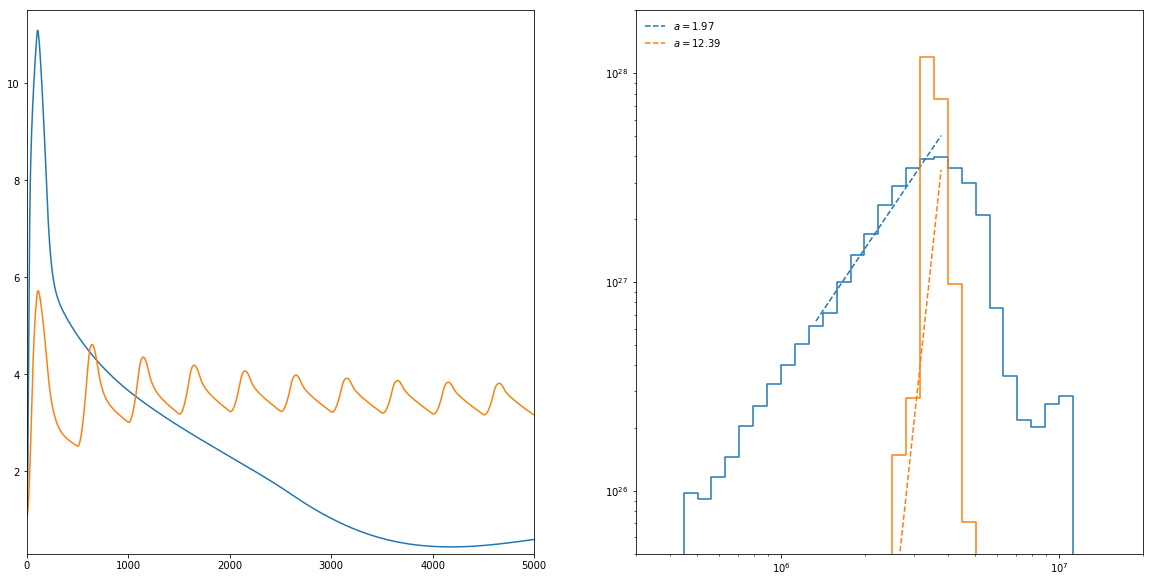

In [25]:
# Heating setup
Heq = 2e-3
duration = 200.
fig,ax = plt.subplots(1,2,figsize=(20,10))
# 1 nanoflare
N = 1
tn = (config['total_time'] - N*duration)/N
events = []
events = []
for i in range(N):
    events.append({'event':{
        'rise_start': i*(tn + duration),
        'rise_end': i*(tn + duration) + duration/2,
        'decay_start': i*(tn + duration) + duration/2,
        'decay_end': i*(tn + duration) + duration,
        'magnitude': 2*config['total_time']*Heq/N/duration,
    }
    }
    )
config['heating']['events'] = events
res = run_ebtel(config,'/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/')
ax[0].plot(res['time'],res['electron_temperature'].to(u.MK),color='C0')
bins_T,H = calculate_em(res['time'],res['electron_temperature'],res['density'],config['loop_length'])
plot_hist(ax[1],H.value,bins_T.value,)
a,b,T_fit = fit_slope(bins_T,H,T0=1.25e6*u.K,T1=4e6*u.K)
ax[1].plot(T_fit,b*T_fit**a,color='C0',ls='--',label=f'$a={a:.2f}$')
# Repeated nanoflares
N = 10
tn = (config['total_time'] - N*duration)/N
events = []
for i in range(N):
    events.append({'event':{
        'rise_start': i*(tn + duration),
        'rise_end': i*(tn + duration) + duration/2,
        'decay_start': i*(tn + duration) + duration/2,
        'decay_end': i*(tn + duration) + duration,
        'magnitude': 2*config['total_time']*Heq/N/duration,
    }
    }
    )
config['heating']['events'] = events
res = run_ebtel(config,'/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/')
ax[0].plot(res['time'],res['electron_temperature'].to(u.MK),color='C1')
bins_T,H = calculate_em(res['time'],res['electron_temperature'],res['density'],config['loop_length'])
plot_hist(ax[1],H.value,bins_T.value,color='C1')
a,b,T_fit = fit_slope(bins_T,H,T0=1.25e6*u.K,T1=4e6*u.K)
ax[1].plot(T_fit,b*T_fit**a,color='C1',ls='--',label=f'$a={a:.2f}$')
# Labels and limits
ax[0].set_xlim(0,5e3)
ax[0].set_ylim(0.3,11.5)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(5e25,2e28)
ax[1].set_xlim(3e5,2e7)
ax[1].legend(loc=2,frameon=False)

## EM Loci

In [224]:
URL = 'http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t2_mrt.txt'

In [303]:
tmp = urllib.request.urlopen(URL).readlines()
tmp = [t.decode('utf-8') for t in tmp]

In [304]:
tmp

['Title: A Systematic Survey of High Temperature Emission in Solar Active Regions\n',
 'Authors: Warren H.P., Winebarger A.R., Brooks D.H.\n',
 'Table: Differential Emission Measure Model\n',
 '================================================================================\n',
 'Byte-by-byte Description of file: apj446760t2_mrt.txt\n',
 '--------------------------------------------------------------------------------\n',
 '   Bytes Format Units   Label   Explanations\n',
 '--------------------------------------------------------------------------------\n',
 '   1-  2 I2     ---     Region  Active region\n',
 '   4-  6 A3     ---     Inst    Instrument (1)\n',
 '   8- 22 A15    ---     ID      Line/Wavelength identifier\n',
 '  24- 31 F8.2   ---     OInt    Observed intensity\n',
 '  33- 39 F7.2   ---   e_OInt    Error in OInt\n',
 '  41- 48 F8.2   ---     DInt    Differential emission measure intensity\n',
 '  50- 53 F4.2   ---     Ratio   Ratio of OInt to DInt\n',
 '-----------------

In [226]:
columns = [c.strip().split()[4] for c in tmp[8:15]]

In [227]:
columns = columns[:2] + ['Element','Ion','Wavelength'] + columns[3:]

In [228]:
data = [t for t in tmp[19:] if 'AIA' not in t]

In [229]:
data = [t.strip().split() for t in data]

In [230]:
df = pandas.DataFrame(data, columns=columns)

In [231]:
region = df['Region'].astype(int)
df = df.drop(columns='Region').assign(Region=region)
for c in ['OInt','e_OInt','DInt','Wavelength','Ratio']:
    tmp = df[c].astype(float)
    df = df.drop(columns=c)
    df[c] = tmp

In [232]:
ion = df['Ion'].map(roman.fromRoman)
df = df.drop(columns='Ion').assign(Ion=ion)

In [233]:
qtab = QTable.from_pandas(df[df['Region'] == 2])
qtab['Wavelength'].unit = u.angstrom
for c in ['OInt','e_OInt','DInt']:
    qtab[c].unit = u.erg / (u.cm**2) / u.s / u.steradian

In [234]:
qtab

Inst,Element,Region,OInt,e_OInt,DInt,Wavelength,Ratio,Ion
,,,erg / (cm2 s sr),erg / (cm2 s sr),erg / (cm2 s sr),Angstrom,,
str3,str2,int64,float64,float64,float64,float64,float64,int64
EIS,Si,2,74.86,16.52,73.75,275.368,1.02,7
EIS,Fe,2,135.84,29.95,143.55,188.497,0.95,9
EIS,Fe,2,89.03,19.61,88.13,197.862,1.01,9
EIS,Fe,2,545.44,120.1,394.9,184.536,1.38,10
EIS,Fe,2,1829.25,402.72,2126.15,180.401,0.86,11
EIS,Fe,2,1214.33,267.18,1059.57,188.216,1.15,11
EIS,S,2,154.18,33.96,137.75,264.233,1.12,10
EIS,Si,2,583.07,128.33,670.48,258.375,0.87,10


In [286]:
ion_names = list(set([f'{el} {i}' for el,i in zip(qtab['Element'],qtab['Ion'])]))

In [287]:
Te = np.logspace(5.5,7.2,100)*u.K
ne = [1e9]/(u.cm**3)

In [288]:
contribution_functions = {}
for i in ion_names:
    ion = fiasco.Ion(i,Te,abundance_filename='sun_coronal_1992_feldman')
    contribution_functions[i] = {'G': ion.contribution_function(ne).squeeze(),
                                 'w': ion.transitions.wavelength[~ion.transitions.is_twophoton]}

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/fiasco-0.1.dev226-py3.7.egg/fiasco/ion.py:221: RuntimeWarning: invalid value encountered in greater
  return u.Quantity(np.where(ex_rate > 0., ex_rate, 0.), u.cm**3/u.s).T


In [289]:
color_key = {el:f'C{i}' for i,el in enumerate(list(set(qtab['Element'].tolist())))}

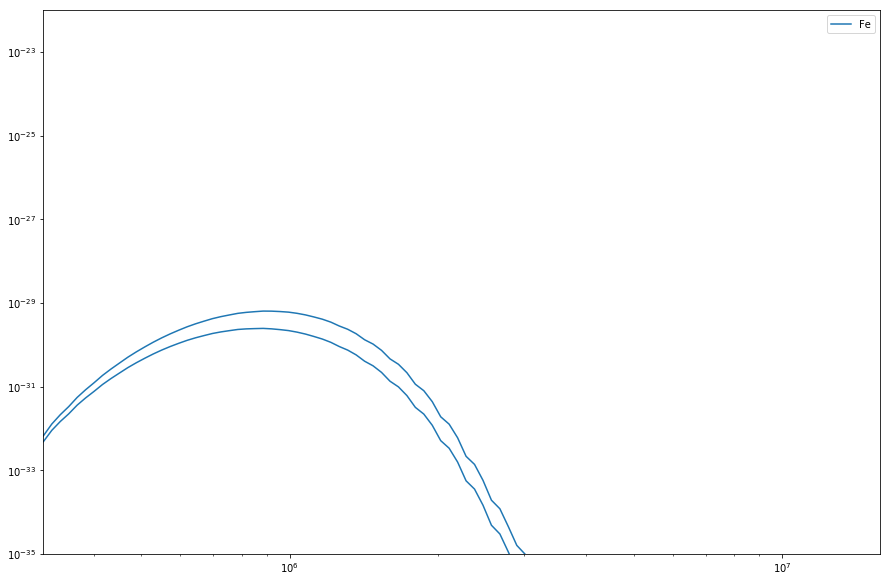

In [323]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
for r in qtab:
    name = f"{r['Element']} {r['Ion']}"
    if name != 'Fe 9':
        continue
    i_w = np.argmin(np.fabs(r['Wavelength'] - contribution_functions[name]['w']))
    G = contribution_functions[name]['G'][:,i_w]
    ax.plot(Te,G,color=color_key[r['Element']],label=r['Element'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-35,1e-22)
ax.set_xlim(Te[[0,-1]].value)
lines,labels = [],[]
_lines,_labels = ax.get_legend_handles_labels() 
for li,la in zip(_lines,_labels):
    if la not in labels:
        lines.append(li)
        labels.append(la)
ax.legend(lines,labels)

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


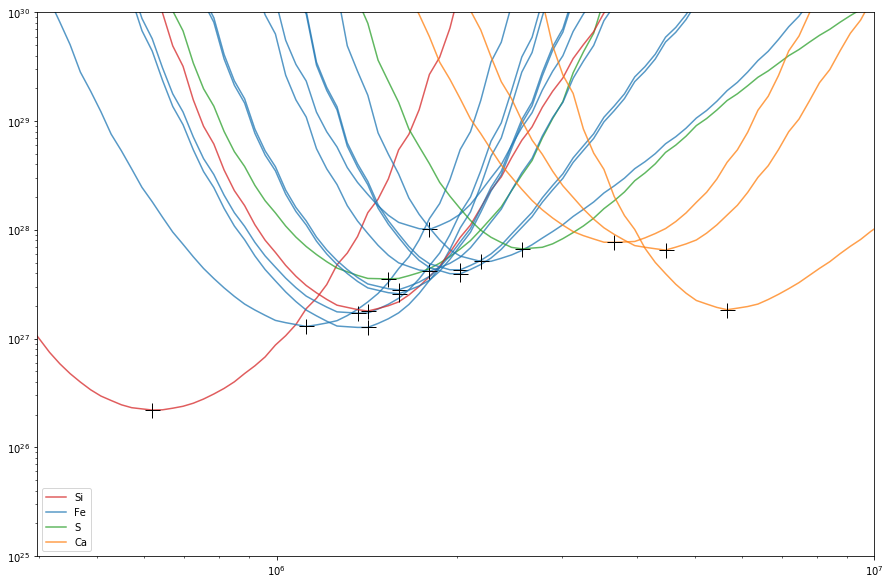

In [343]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
for r in qtab:
    name = f"{r['Element']} {r['Ion']}"
    i_w = np.argmin(np.fabs(r['Wavelength'] - contribution_functions[name]['w']))
    #print(np.fabs(r['Wavelength'] - contribution_functions[name]['w'][i_w])/r['Wavelength'])
    G = contribution_functions[name]['G'][:,i_w]/(4*np.pi*u.steradian)
    em = r['OInt']/G
    ax.plot(Te,em,
            color=color_key[r['Element']],
            label=r['Element'],
            alpha=0.75
           )
    ax.plot(Te[np.argmin(em)],np.min(em),
            color='k',ls='',
            marker='+',
            markersize=15
           )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e25,1e30)
ax.set_xlim(10**(5.6),1e7)
lines,labels = [],[]
_lines,_labels = ax.get_legend_handles_labels() 
for li,la in zip(_lines,_labels):
    if la not in labels:
        lines.append(li)
        labels.append(la)
ax.legend(
    lines,labels
)

In [305]:
fe9 = fiasco.Ion('Fe 9',Te)

In [308]:
contribution_functions['Fe 9']['G'].shape

(100, 55075)

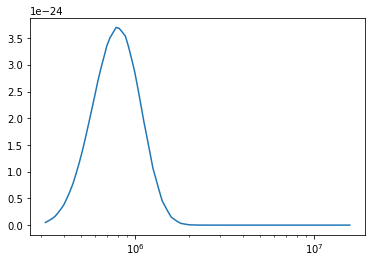

In [311]:
plt.plot(Te,contribution_functions['Fe 9']['G'][:,0])
plt.xscale('log')

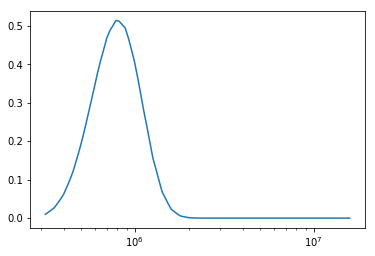

In [306]:
plt.plot(Te,fe9.ioneq)
plt.xscale('log')

(array([ 28551., 297511.,      0.,  51566.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5]),
 <a list of 4 Patch objects>)

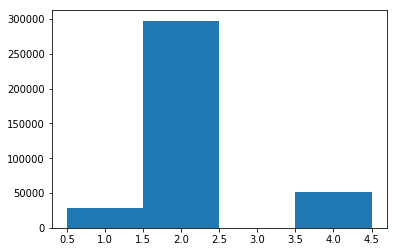

In [341]:
plt.hist(fe9._scups['bt_type'],bins=[0.5,1.5,2.5,3.5,4.5])

(array([ 63., 287., 106.,  23.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5]),
 <a list of 4 Patch objects>)

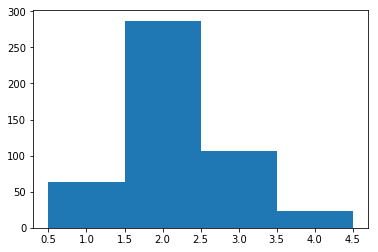

In [342]:
plt.hist(fiasco.Ion('S 10',Te)._scups['bt_type'],bins=[0.5,1.5,2.5,3.5,4.5])

In [332]:
for name in ion_names:
    foo = fiasco.Ion(name,Te)
    print(name)
    print(foo._scups['bt_t'].shape)

S 10
(479,)
Fe 14
(1672,)
S 13
(373,)
Fe 12
(22475, 20)
Fe 16
(9397, 15)
Fe 11
(31344, 20)
Ca 14
(440, 5)
Fe 10
(12948, 12)
Fe 13
(13311, 20)
Si 7
(415, 5)
Si 10
(20706, 15)
Ca 17
(373, 5)
Ca 15
(249,)
Fe 9
(377628,)
Fe 15
(1122, 5)


In [333]:
foo = fiasco.Ion('S 10',Te)

In [334]:
foo._scups['bt_t']

array([array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
       array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
       array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
       array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
       array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
       array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
       array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
       array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
       array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
       array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
       array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
       array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
       array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
       array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
       array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
       array([0.   , 0.125, 0.25 , 0.375, 0.5 

In [346]:
kBTE = np.outer(const.k_B.cgs*fe9.temperature, 1.0/fe9._scups['delta_energy'].to(u.erg))

In [348]:
upsilon = burgess_tully_descale_vectorize(
    fe9._scups['bt_t'],
    fe9._scups['bt_upsilon'],
    kBTE.T,
    fe9._scups['bt_c'],
    fe9._scups['bt_type']
)

In [349]:
kBTE.shape

(100, 377628)

In [358]:
upsilon_1 = burgess_tully_descale(
    fe9._scups['bt_t'][1000],
    fe9._scups['bt_upsilon'][1000],
    kBTE[:,1000],
    fe9._scups['bt_c'][1000],
    fe9._scups['bt_type'][1000]
)

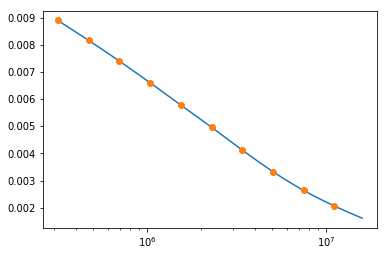

In [359]:
plt.plot(Te,upsilon[1000,:])
plt.plot(Te,upsilon_1,marker='o',markevery=10,ls='')
plt.xscale('log')